In [2]:
import pandas as pd

# Load logs
df = pd.read_csv(r"C:\Users\Tanish\Documents\VS\ThreatHawk\logs\generated_logs.csv")

# Preview
df.head()


,timestamp,username,role,action
0,2025-08-06 13:58:58,eve,malicious_actor,access_server
1,2025-08-01 19:39:58,eve,malicious_actor,privilege_escalation
2,2025-07-31 16:20:58,eve,malicious_actor,access_server
3,2025-08-06 18:50:58,dave,hr,login
4,2025-08-05 02:01:58,charlie,intern,login


In [3]:
from sklearn.preprocessing import LabelEncoder
import numpy as np

df['timestamp'] = pd.to_datetime(df['timestamp'])

# Convert timestamp into numerical features
df['hour'] = df['timestamp'].dt.hour
df['dayofweek'] = df['timestamp'].dt.dayofweek

# Encode categorical features
le_user = LabelEncoder()
le_role = LabelEncoder()
le_action = LabelEncoder()

df['user_encoded'] = le_user.fit_transform(df['username'])
df['role_encoded'] = le_role.fit_transform(df['role'])
df['action_encoded'] = le_action.fit_transform(df['action'])

# Final feature set
features = df[['user_encoded', 'role_encoded', 'action_encoded', 'hour', 'dayofweek']]


In [4]:
from sklearn.ensemble import IsolationForest

model = IsolationForest(contamination=0.1, random_state=42)
model.fit(features)

# Predict anomalies (1 = normal, -1 = anomaly)
df['anomaly'] = model.predict(features)


In [5]:
df[df['anomaly'] == -1].head(10)


,timestamp,username,role,action,hour,dayofweek,user_encoded,role_encoded,action_encoded,anomaly
5,2025-08-04 22:13:58,bob,admin,read_code,22,0,1,0,7,-1
56,2025-08-04 01:08:58,alice,engineer,read_code,1,0,0,1,7,-1
62,2025-08-04 22:47:58,dave,hr,read_hr_docs,22,0,3,2,8,-1
72,2025-08-05 22:13:58,alice,engineer,access_server,22,1,0,1,0,-1
79,2025-08-04 21:52:58,alice,engineer,read_code,21,0,0,1,7,-1
91,2025-08-03 01:58:58,alice,engineer,edit_code,1,6,0,1,2,-1
100,2025-08-05 01:38:58,alice,engineer,read_code,1,1,0,1,7,-1
105,2025-08-04 05:34:58,eve,malicious_actor,access_server,5,0,4,4,0,-1
112,2025-08-03 02:46:58,alice,engineer,edit_code,2,6,0,1,2,-1
113,2025-08-03 17:53:58,eve,malicious_actor,access_server,17,6,4,4,0,-1


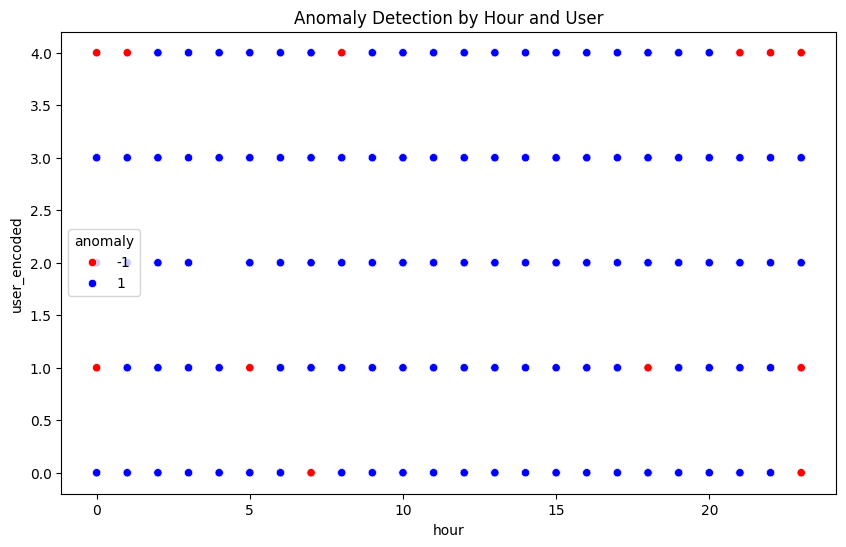

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='hour', y='user_encoded', hue='anomaly', palette={1: 'blue', -1: 'red'})
plt.title("Anomaly Detection by Hour and User")
plt.show()


In [7]:
# Decode back to usernames
df['username_decoded'] = le_user.inverse_transform(df['user_encoded'])

# See anomalies by user
df[df['anomaly'] == -1]['username_decoded'].value_counts()


username_decoded
eve        18
alice      17
bob        11
dave        3
charlie     1
Name: count, dtype: int64

In [8]:
risk_scores = df[df['anomaly'] == -1]['username_decoded'].value_counts().reset_index()
risk_scores.columns = ['username', 'anomaly_count']
risk_scores['risk_score'] = risk_scores['anomaly_count'] / df['username_decoded'].value_counts().loc[risk_scores['username']].values
risk_scores.sort_values(by='risk_score', ascending=False)


,username,anomaly_count,risk_score
0,eve,18,0.165138
1,alice,17,0.165049
2,bob,11,0.110000
3,dave,3,0.031915
4,charlie,1,0.010638


In [9]:
# Save anomaly CSV for backend
df_anomalies = df[df['anomaly'] == -1]
df_anomalies['username'] = le_user.inverse_transform(df_anomalies['user_encoded'])
df_anomalies.to_csv(r"C:\Users\Tanish\Documents\VS\ThreatHawk\ml\anomalies.csv", index=False)


C:\Users\Tanish\AppData\Local\Temp\ipykernel_37008\1144087900.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_anomalies['username'] = le_user.inverse_transform(df_anomalies['user_encoded'])
